In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

# --- 1. DATA DOWNLOAD (PPH ETF, 2018-2022) ---

# Ticker corrected for the Pharma/Biotech ETF
PHARMA_ETF_TICKER = "PPH"
START_DATE = "2018-01-01"
END_DATE = "2022-12-31"

# auto_adjust=False is used to ensure the 'Adj Close' column is present
df = yf.download(PHARMA_ETF_TICKER, start=START_DATE, end=END_DATE, auto_adjust=False)


# --- 2. FEATURE ENGINEERING FUNCTION (Corrected) ---

def create_price_features(df: pd.DataFrame, target_shift: int = 15, delta: float = 0.003) -> tuple:
    """
    Calculates essential financial features (X) and the binary target (Y) for
    a classical ML classification model, based on a 15-day outlook.

    :param df: DataFrame with price data (Adj Close, High, Low, Volume).
    :param target_shift: Number of trading days into the future for the target (e.g., 15 days).
    :param delta: Minimum return threshold for a significant Buy/Sell signal (e.g., 0.3%).
    :return: Tuple (X_features, Y_target).
    """
    df = df.copy()

    # --- 1. Target Y Generation ---
    # Future Return calculation: 15-day change
    df['Future_Return'] = (df['Adj Close'].shift(-target_shift) / df['Adj Close']) - 1

    # Target Y: 1=Buy, 0=Sell, NaN=Hold (for low-conviction movements)
    df['Target_Y'] = np.where(df['Future_Return'] > delta, 1,
                       np.where(df['Future_Return'] < -delta, 0, np.nan))


    # --- 2. Momentum Features ---

    # Simple Returns (1, 5, 20 days)
    for window in [1, 5, 20]:
        df[f'Return_{window}d'] = df['Adj Close'].pct_change(window)

    # Simple Moving Averages (SMA)
    df['SMA_10d'] = df['Adj Close'].rolling(window=10).mean()
    df['SMA_50d'] = df['Adj Close'].rolling(window=50).mean()

    # MA Crossover Ratio
    df['MA_Crossover_Ratio'] = df['SMA_10d'] / df['SMA_50d']


    # --- 3. Volatility Features ---

    # Historical Volatility
    df['Vol_20d'] = df['Return_1d'].rolling(window=20).std()

    # Average True Range (ATR) calculation
    high_minus_low = df['High'] - df['Low']
    high_minus_prev_close_abs = (df['High'] - df['Adj Close'].shift(1)).abs()
    low_minus_prev_close_abs = (df['Low'] - df['Adj Close'].shift(1)).abs()

    # Use np.maximum.reduce to safely calculate True Range without DataFrame creation errors
    df['True_Range'] = np.maximum.reduce([high_minus_low,
                                          high_minus_prev_close_abs,
                                          low_minus_prev_close_abs])

    df['ATR_14d'] = df['True_Range'].rolling(window=14).mean()


    # --- 4. Volume Features ---

    # Rolling Volume Average
    df['Vol_Avg_5d'] = df['Volume'].rolling(window=5).mean()

    # Volume Delta
    df['Vol_Delta'] = df['Volume'].pct_change(1)

    # --- 5. Final Cleaning & X/Y Isolation ---

    # Drop rows where rolling windows or the target could not be calculated (NaN)
    df = df.dropna()

    # X (Features): drop raw price columns and intermediate targets
    X = df.drop(columns=['Future_Return', 'Target_Y', 'True_Range', 'Adj Close', 'High', 'Low', 'Open', 'Close'])
    Y = df['Target_Y']

    return X, Y


# --- 3. EXECUTION AND VALIDATION ---

X_features, Y_target = create_price_features(df)

print("Features (X) Head:")
print(X_features.head())
print("\nTarget (Y) Value Counts (Check for class imbalance):")
print(Y_target.value_counts(normalize=True))

[*********************100%***********************]  1 of 1 completed

Features (X) Head:
Price      Volume Return_1d Return_5d Return_20d    SMA_10d    SMA_50d  \
Ticker        PPH                                                        
Date                                                                     
2018-03-14   6800 -0.005227  0.016891   0.018471  50.406564  52.125359   
2018-03-15  25400 -0.006610  0.000512  -0.003570  50.562881  52.096169   
2018-03-16  58500  0.003753 -0.005242  -0.019173  50.684654  52.064560   
2018-03-19  41500 -0.015129 -0.026382  -0.043737  50.679472  52.013088   
2018-03-20  26900 -0.007249 -0.030181  -0.036838  50.648383  51.946934   

Price      MA_Crossover_Ratio   Vol_20d   ATR_14d Vol_Avg_5d Vol_Delta  
Ticker                                                                  
Date                                                                    
2018-03-14           0.967026  0.013032  8.362257    10640.0 -0.413793  
2018-03-15           0.970568  0.012679  8.312743    13920.0  2.735294  
2018-03-16           0.

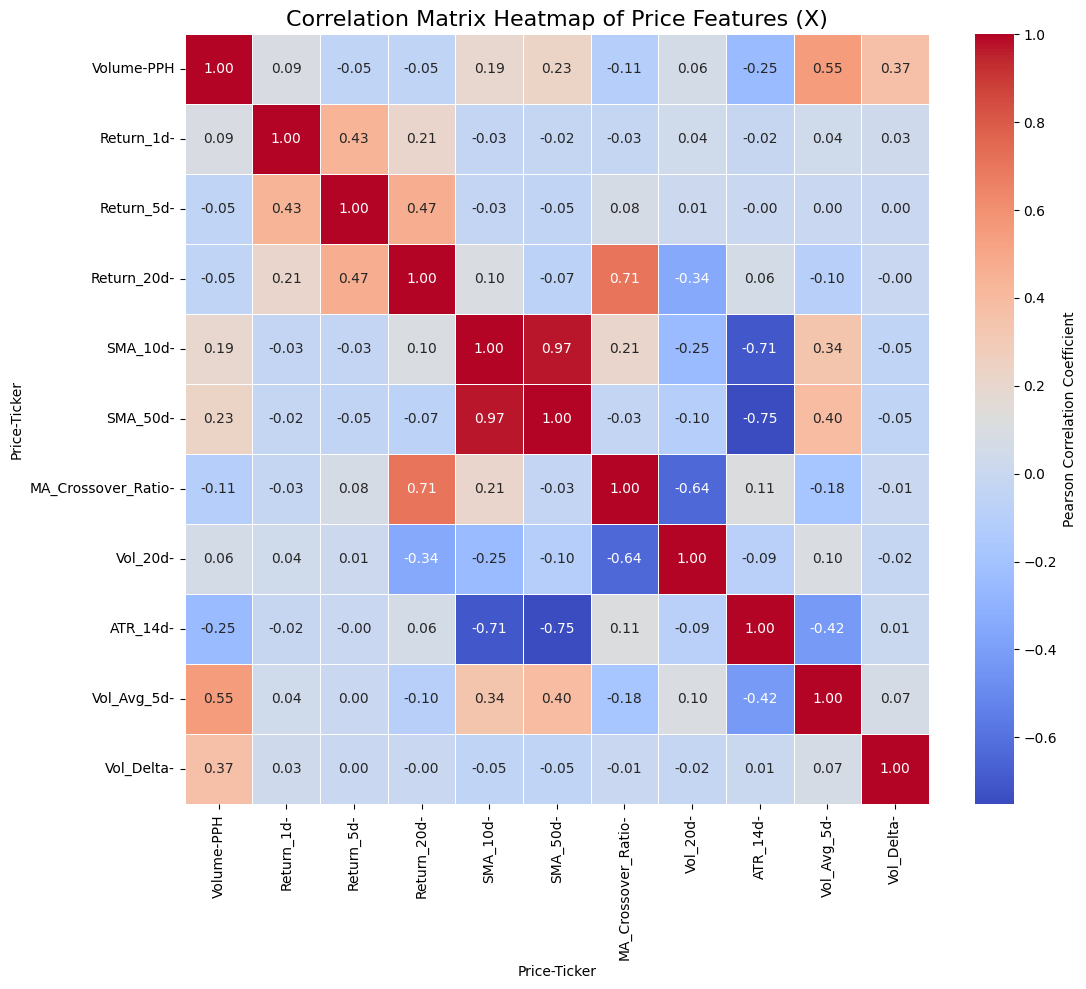

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate the Correlation Matrix
# The .corr() Pandas method calculates the Pearson correlation coefficient
correlation_matrix = X_features.corr()

# 2. Configure the Matplotlib Figure
plt.figure(figsize=(12, 10)) # Adjust size for better readability

# 3. Create the Heatmap
# annot=True displays the correlation values on the map
# cmap='coolwarm' is a standard color palette for correlations (blue for negative, red for positive)
# fmt='.2f' formats annotations with two decimals
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=.5,
    cbar_kws={'label': 'Pearson Correlation Coefficient'}
)

# 4. Add Title and Display
plt.title('Correlation Matrix Heatmap of Price Features (X)', fontsize=16)
plt.show()